### импорт модулей


In [3]:
import re
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from collections import Counter 
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import string
lst_stopwords = nltk.corpus.stopwords.words('russian')
lst_stopwords.extend(['…', '«', '»', '...'])


### импорт файла (поменяйте на / все \  и оставьте r) 


In [27]:
def import_file(file_path):
    df_raw = pd.read_excel(file_path)
    df_raw.dropna(inplace=True)
    df_raw.rename(columns={'text': 'content'}, inplace=True)
    return df_raw

In [28]:
df_raw=import_file(r"../clust_analize/Московский постамат_Дата-cет_Этап 1.xlsx",)


In [29]:
df_raw #весь датасет

,Комментарий,Дата,Оценка,Сумма заказа
0,"Благодарю за заказ! Рада получению, но заказыв...",2022-12-15T15:58:09.796075+03:00,3,2450.0
1,"Все подошло, отличное качество",2022-11-07T23:37:52.541536+03:00,5,699.0
2,"Упаковано все хорошо, только транспортировочна...",2022-12-13T21:24:31.155951+03:00,4,954.0
3,"Быстро, удобно.",2022-11-09T17:55:44.379634+03:00,5,269.0
4,👍,2022-11-09T20:49:11.383462+03:00,5,229.0
...,...,...,...,...
124995,Качество звука на 3 из 10👎,2022-10-21T06:42:45.861705+03:00,5,899.0
124996,"Все организовано хорошо, но от нас долековато.",2022-10-25T07:53:15.062592+03:00,5,754.0
124997,"Удобное получение. Приятно, что можно зайти в ...",2022-10-22T11:25:16.25381+03:00,5,217.0
124998,Отлично.,2022-10-24T21:42:42.771919+03:00,5,459.0


In [7]:
def clean_text(text, tokenizer, stopwords):

    text = str(text).lower()  
    text = re.sub(r"\[(.*?)\]", "", text)  
    text = re.sub(r"\s+", " ", text)  
    text = re.sub(r"\w+…|…", "", text)  
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  

    tokens = tokenizer(text)  
    tokens = [t for t in tokens if not t in lst_stopwords]  
    tokens = ["" if t.isdigit() else t for t in tokens]  
    tokens = [t for t in tokens if len(t) > 1] 
    return tokens

In [30]:
def prep_tokens(df_raw):
    text_columns = ["Комментарий"]
    # df_raw['content'] = df_raw['content'].fillna(" ")
    # for col in text_columns:
    #     df_raw[col] = df_raw[col].astype(str)
    # создаем текст основанный на content title и tag
    df_raw["text"] = df_raw[text_columns].apply(lambda x: " | ".join(x), axis=1)
    df_raw["tokens"] = df_raw["text"].map(lambda x: clean_text(x, word_tokenize, lst_stopwords))
    _, idx = np.unique(df_raw["tokens"], return_index=True)
    df_raw = df_raw.iloc[idx, :]

    # Remove empty values
    df_raw = df_raw.loc[df_raw.tokens.map(lambda x: len(x) > 0), ["text", "tokens"]]
    return df_raw
    

In [31]:
prep_data=prep_tokens(df_raw)

In [32]:
prep_data

,text,tokens
73222,"04 и 05.07.2022г. не было доступа к постомату,...","[05072022г, доступа, постомату, магазин, входе..."
414,100гр только!,[100гр]
74679,"100%хлопок, соответствует размеру","[100хлопок, соответствует, размеру]"
41873,100₽ красная цена\nДумаю если воздух грести не...,"[100₽, красная, цена, думаю, воздух, грести, р..."
38120,10из10,[10из10]
...,...,...
53034,🤩🤗👏,[🤩🤗👏]
35491,🤩🤩🤩,[🤩🤩🤩]
46714,🤩🤩🤩🤩,[🤩🤩🤩🤩]
68385,🤬📦🖕,[🤬📦🖕]


In [33]:
docs = prep_data["text"].values
tokenized_docs = prep_data["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [34]:
def vectorize(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

### создаем модель и получаем вектора для кластерного анализа

In [35]:
model = Word2Vec(sentences=prep_data['tokens'].values, vector_size=100, window=5, min_count=1, workers=4)

In [36]:
vectorized_docs= vectorize(prep_data['tokens'], model=model)
len(vectorized_docs), len(vectorized_docs[0])

(91915, 100)

In [37]:
vectorized_docs

[array([-0.9914853 ,  0.7503263 , -0.29373425,  0.5645733 ,  0.4788733 ,
        -0.7380732 , -0.09577373,  0.9116299 , -1.1427156 , -0.17946325,
        -0.39530122, -1.1242448 , -0.00494163,  0.83420444,  0.53786343,
        -0.22421902,  0.815766  , -0.91751766, -0.1573364 , -1.2140371 ,
         0.578619  ,  0.62123656,  0.7719736 , -0.28312248,  0.62668014,
        -0.2522906 , -0.99574095, -0.3533193 , -0.877083  , -0.2943607 ,
         0.63552886,  0.6049472 ,  1.0897434 ,  0.3393681 , -0.08295231,
         0.90716684, -0.68125814,  0.06087877, -0.700086  , -0.6765976 ,
         0.13202423, -0.34131682,  0.12597679,  0.09458716,  0.80326754,
        -0.5752907 , -0.82631737, -0.35278028,  0.10126744,  0.05525996,
        -0.09072661, -0.03119497, -0.21961349,  0.0470277 , -0.19304927,
        -0.7122699 , -0.14895317,  0.19158381, -0.66989005, -0.17061722,
         0.6296163 , -0.4145071 ,  0.384682  ,  0.17704122, -1.0355985 ,
         0.02431873, -0.47091675,  0.43167278, -0.9

In [38]:
prep_data['vectors'] =vectorized_docs
prep_data.fillna('')

,text,tokens,vectors
73222,"04 и 05.07.2022г. не было доступа к постомату,...","[05072022г, доступа, постомату, магазин, входе...","[-0.9914853, 0.7503263, -0.29373425, 0.5645733..."
414,100гр только!,[100гр],"[0.04527662, -0.02567693, 0.06023504, 0.011318..."
74679,"100%хлопок, соответствует размеру","[100хлопок, соответствует, размеру]","[0.42752245, -0.2024896, -0.20035537, 0.314042..."
41873,100₽ красная цена\nДумаю если воздух грести не...,"[100₽, красная, цена, думаю, воздух, грести, р...","[-0.00782092, 0.12900183, -0.18480107, -0.0022..."
38120,10из10,[10из10],"[0.0070147063, 0.0069573657, 0.001211852, -0.0..."
...,...,...,...
53034,🤩🤗👏,[🤩🤗👏],"[0.005571321, 0.005428286, 0.005887027, 0.0034..."
35491,🤩🤩🤩,[🤩🤩🤩],"[0.0050080228, 0.0094901, -0.009820846, 0.0031..."
46714,🤩🤩🤩🤩,[🤩🤩🤩🤩],"[-0.004092746, -0.0038939083, -0.006827849, -0..."
68385,🤬📦🖕,[🤬📦🖕],"[-0.0076446235, -0.0021137404, -0.009652478, -..."


In [39]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):

    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

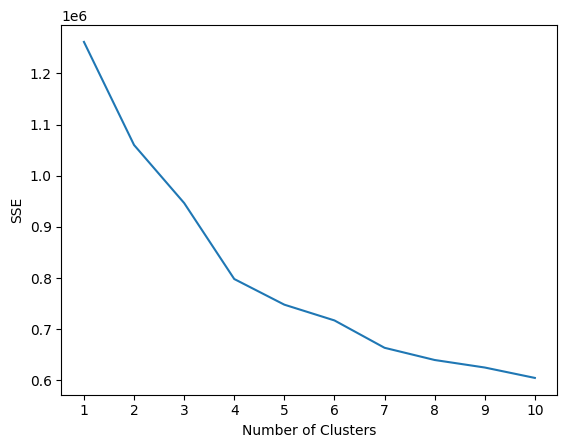

In [65]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = MiniBatchKMeans(n_clusters=k,batch_size=1000 ,**kmeans_kwargs)
    kmeans.fit(prep_data['vectors'].tolist())
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [66]:
sse

[1261418.1812437011,
 1060035.9757281623,
 946648.2202566807,
 798156.540071715,
 748030.28059939,
 717245.0503909745,
 663787.1799148599,
 639947.4891222985,
 625247.7933009431,
 604920.2285338648]

In [68]:
clustering, cluster_labels = mbkmeans_clusters(X=prep_data['vectors'].tolist(),k=7, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})

c:\Users\Jora\Desktop\hack_lct\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7
Silhouette coefficient: 0.16
Inertia:665069.6256930404
Silhouette values:
    Cluster 1: Size:26549 | Avg:0.34 | Min:0.04 | Max: 0.52
    Cluster 0: Size:3748 | Avg:0.22 | Min:-0.02 | Max: 0.44
    Cluster 3: Size:11582 | Avg:0.12 | Min:-0.16 | Max: 0.37
    Cluster 6: Size:10641 | Avg:0.10 | Min:-0.12 | Max: 0.32
    Cluster 4: Size:9365 | Avg:0.08 | Min:-0.21 | Max: 0.34
    Cluster 2: Size:11256 | Avg:0.05 | Min:-0.25 | Max: 0.31
    Cluster 5: Size:18774 | Avg:0.04 | Min:-0.24 | Max: 0.27


In [69]:
print("Самые популярные темы в кластере:")
for i in range(7):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Самые популярные темы в кластере:
Cluster 0: торговый далеко соседнем постмат живу 
Cluster 1: значит поставила приехали уверен нормальной 
Cluster 2: утром пятницу богу обещано продлил 
Cluster 3: пастомата висит кассе кабинете никого 
Cluster 4: тюбик мягком вдребезги грязи вскрыт 
Cluster 5: порадовал 👍👍👍 класс 👍🏼 молодец 
Cluster 6: задержек молодцы замечательно своевременно четко 


In [86]:
test_cluster = 6
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")

Всё доставлено чётко, вовремя, в лучшем виде, спасибо.
-------------
Как обычно, все пришло вовремя, все работает )) очень довольна, быстро, товар качественный , спасибо
-------------
Всё отлично: доставили быстро, упаковано аккуратно, очень вкусная каша! Спасибо!
-------------
Доставка быстрая. Упаковано всё надёжно. Мак чистый. Спасибо за качественный товар.
-------------
Благодарю всё пришло время отлично упаковано!
С товаром также всё в порядке!
Спасибо за хороший сервис!❤❤❤
-------------
Отлично все!; надежно упаковано, быстро и самое главное, доставлено точно в срок, благодарю ___ ___!))
-------------
Ребёнок в восторге, пришло всё в срок, очень хорошо упаковано, Спасибо за хорошую работу!
-------------
Все отлично. Смартфон новый. Всё хорошо упаковано. Спасибо продавцу и ___у.
-------------
Все отлично быстро забрали, упаковано отлично. Спасибо за вашу работу
-------------
Спасибо огромное всё надёжно упаковано, все в целости и сохранности, тарелки просто супер!!!! Спасибо прода